In [1]:
import sys
sys.path.append("../../.")
import os
import jax
import jax.numpy as jnp
from util_funcs import make_gif, pixel_to_physical, plot_modes, plot_modes_normalized, plot_circle_Lambda, load_hdf5
from neuraldmd import NeuralDMD
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt

Test Model & Plot Modes

In [2]:
# Taken from train_model notebook
r = 24
num_frequencies = 2
fov_x, fov_y = jnp.pi, jnp.pi
key = jax.random.PRNGKey(42)
models_dir = "./models"
plots_dir = "../../../plots"

# Taken from generate_data notebook:
hs_data_dir = "../../../hs_data"
array_name = 'ngEHT'
movie_name = "orbiting_hs"
fractional_noise = 0.05
#####################################

# Load the model
obs_path = os.path.join(hs_data_dir, f"{array_name}/{movie_name}_f{fractional_noise}")
model = NeuralDMD(r=r, key=key, hidden_size=256, layers=4, num_frequencies=2,
                 temporal_latent_dim=32, temporal_hidden=64, temporal_layers=2)
model = eqx.tree_deserialise_leaves(os.path.join(models_dir, "trained_model.eqx"), model)

/home/as2c/git_testrun/tutorial/Fourier/../.././neuraldmd/model.py:97: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.encoding = SinusoidalEncoding(num_frequencies=num_frequencies)


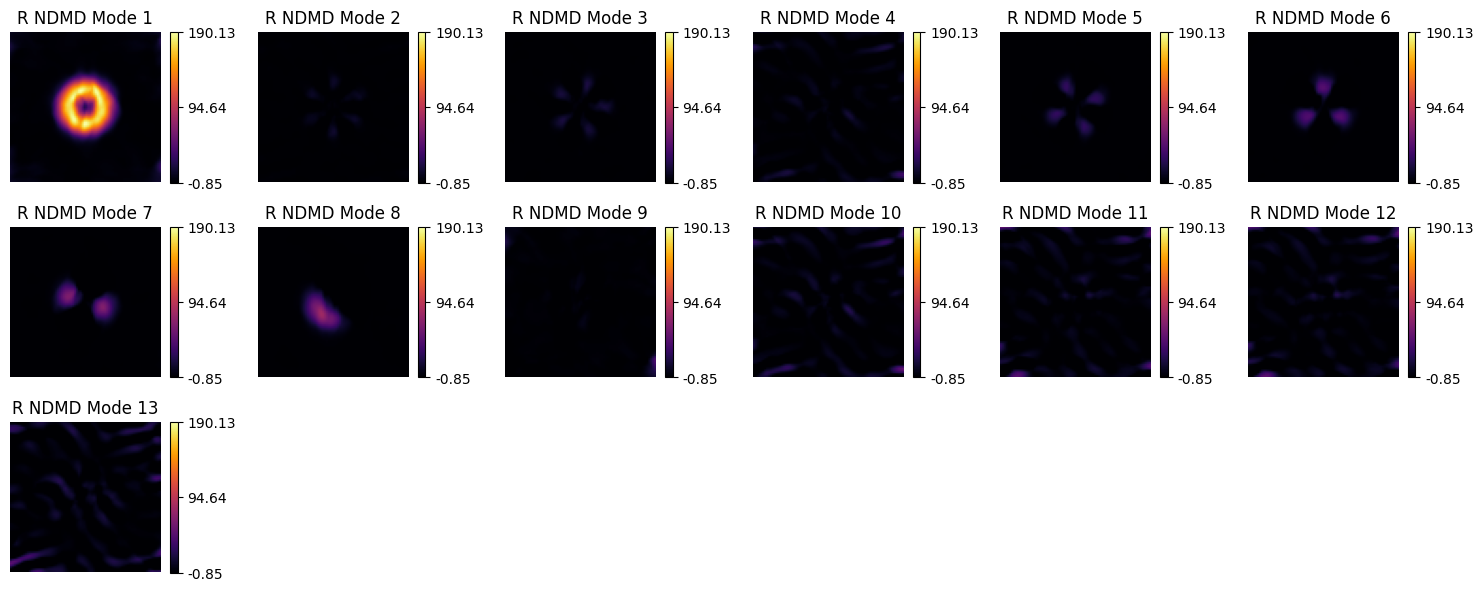

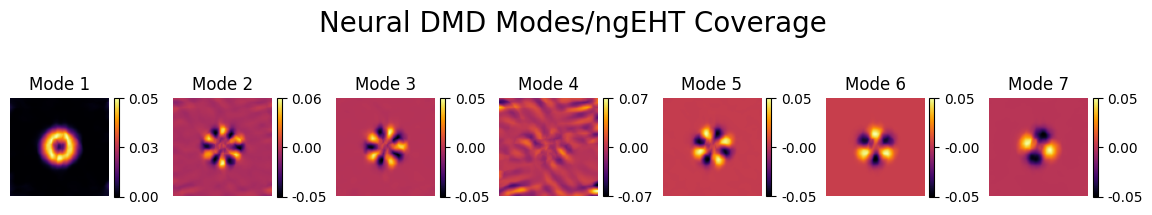

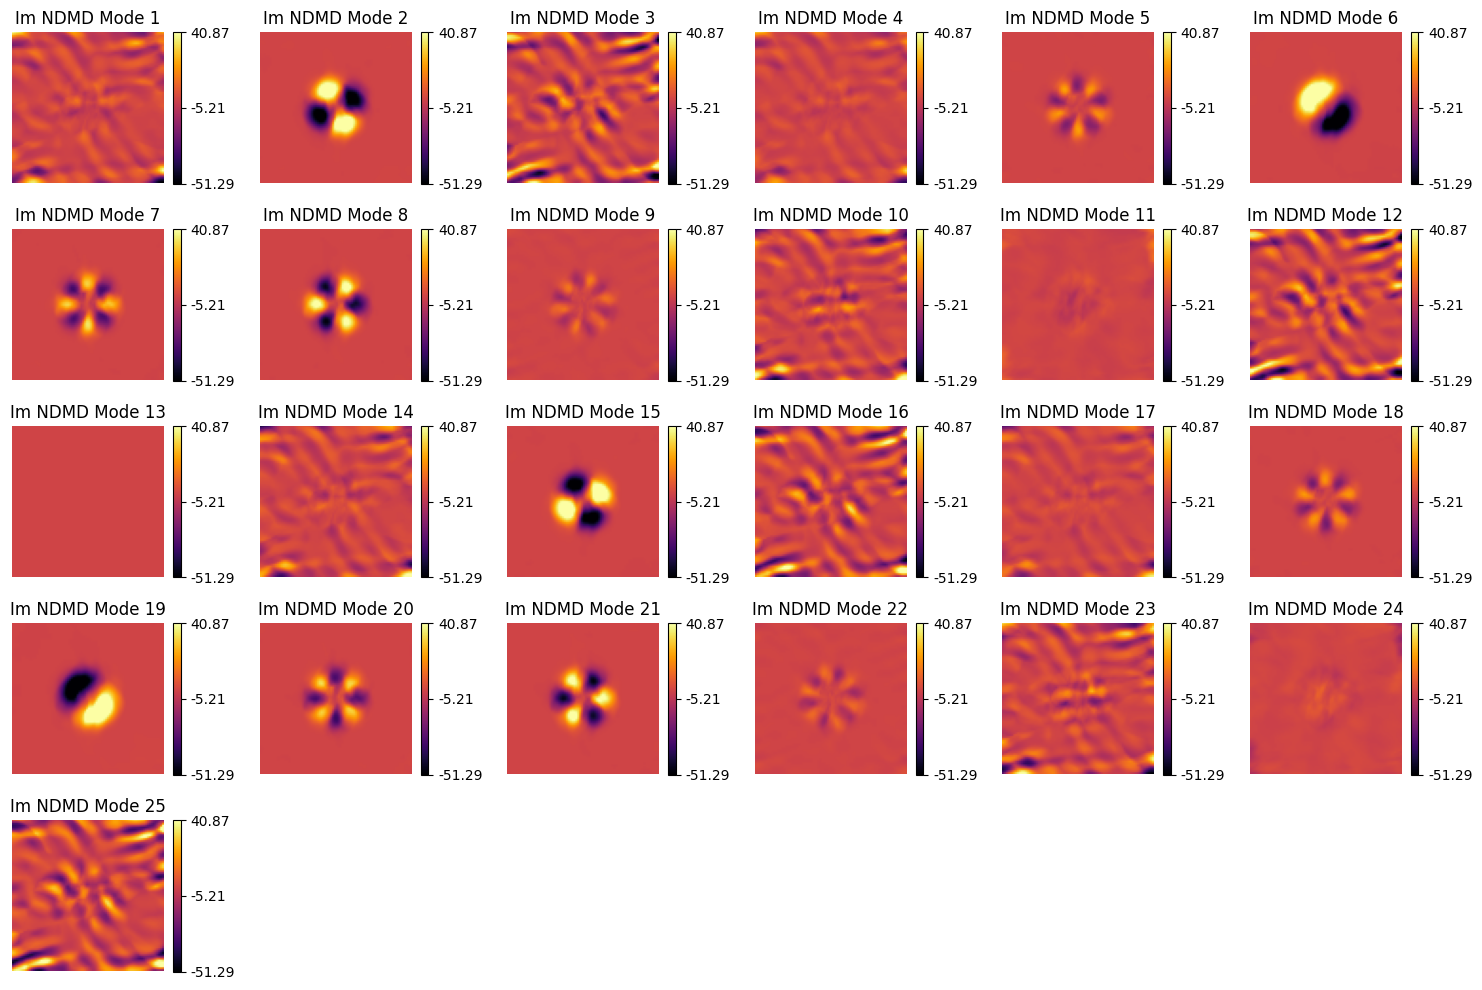

In [3]:
frames, times = load_hdf5(obs_path, "gt_video.hdf5")
num_frames = frames.shape[0]
height, width = frames.shape[1], frames.shape[2]
min_time = times.min()
max_time = times.max()
times = (times - times.min()) / (times.max() - times.min()) # normalize times
frame_max = frames.max()
frame_min = frames.min()
pixel_size_x = fov_x / width
pixel_size_y = fov_y / height

grid_x, grid_y = np.meshgrid(np.arange(height), np.arange(width), indexing='xy') # make grid of x and y coordinates
frames = (frames - frames.min()) / (frames.max() - frames.min()) # normalize frames
make_gif(frames, num_frames, plots_dir, "ground_truth.gif") # make gif of the ground truth video
xy_coords = pixel_to_physical(grid_x, grid_y, width, height, pixel_size_x, pixel_size_y) # convert pixel coordinates to physical coordinates
W0, W_half, W, Omega, b = model(xy_coords) # get the modes, eigenvalues, and initial state from the model
Lambda_half = jnp.exp(Omega)  # temporal factors from Omega
sort_idx = jnp.argsort(jnp.abs(Lambda_half))[::-1] # sort the eigenvalues in descending order
W_half_sorted = W_half[:, sort_idx]  # sort the modes accordingly
W_sorted_concat = jnp.concatenate([W0, W_half_sorted], axis=-1) # concatenate the static mode with all the dynamic modes
plot_modes(W_sorted_concat, height, width, os.path.join(plots_dir, "W_half_sorted.png"), "R NDMD")
plt.show()
plt.close()
plot_modes_normalized(W_sorted_concat[:, :7], height, width, os.path.join(plots_dir, "W_half_sorted_normalized.pdf"), "R NDMD")
plt.show()
plt.close()
plot_modes(-W * 1j, height, width, os.path.join(plots_dir, "W_im_modes.png"), "Im NDMD")
plt.show()
plt.close()

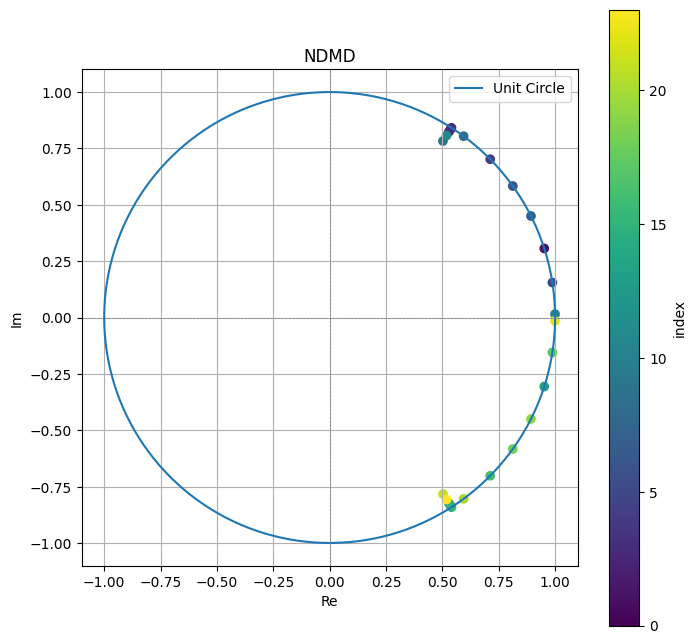

In [4]:
Omega_full = jnp.concatenate([Omega, jnp.conj(Omega)], axis=0)
Lambda = jnp.exp(Omega_full)  # full temporal factors if desired
plot_circle_Lambda(Lambda, "NDMD", os.path.join(plots_dir, "unit_circle.png"))
plt.show()
plt.close()

In [5]:
# get the initial state:
b0_new = b[model.r_half:model.r_half+1]
b_half_new = b[:model.r_half]
##################
lambda_exp = jnp.exp(Omega[:, None] * times[None, :] * 200.0) # compute the exponential of the eigenvalues  
# Generate the video
intensities = jnp.real((2 * jnp.real(jnp.einsum('pr, rt, r -> pt', W_half, lambda_exp, b_half_new)) + W0[:, 0:1] * b0_new[0])) * jax.nn.relu(model.scale)

In [6]:
jnp.mean(intensities < 0), jnp.max(-intensities), jnp.std(intensities[intensities < 0])

(Array(0.36837357, dtype=float32),
 Array(0.33304253, dtype=float32),
 Array(0.0230739, dtype=float32))

In [7]:
X_reconstructed = intensities.T.reshape(num_frames, height, width)
# normalize for visualization 
X_reconstructed = (X_reconstructed - X_reconstructed.min()) / (X_reconstructed.max() - X_reconstructed.min())
# X_reconstructed = (X_reconstructed - frames.min()) / (frames.max() - frames.min())
# X_reconstructed = X_reconstructed / jax.nn.relu(model.scale)  # undo the scaling and biasing
make_gif(X_reconstructed, num_frames, plots_dir, "dmd_reconstruction.gif")

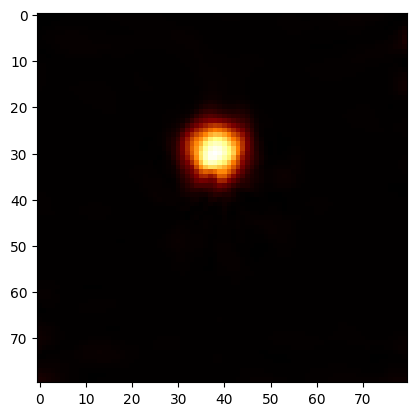

In [8]:
# One frame for example
plt.imshow(X_reconstructed[50], cmap='afmhot')

In [9]:
As_full = jnp.array(np.load(os.path.join(obs_path, "As.npy")))         # shape: (T_full, max_vis, num_samples)
targets_full = jnp.array(np.load(os.path.join(obs_path, "targets.npy")))   # shape: (T_full, max_vis)
sigmas_full = jnp.array(np.load(os.path.join(obs_path, "sigmas.npy")))     # shape: (T_full, max_vis)
# max_sigma = jnp.max(self.sigmas_full)
# min_sigma = jnp.min(self.sigmas_full)
# self.sigmas_full = self.sigmas_full / min_sigma
masks_full = jnp.array(np.load(os.path.join(obs_path, "masks.npy")))       # shape: (T_full, max_vis)
num_vis_list = jnp.array(np.load(os.path.join(obs_path, "num_vis_list.npy")))

# intensities = intensities * model.scale
vis_pred = jnp.einsum('tvp, pt -> tv', As_full, intensities.astype(complex))
# vis_pred = jnp.einsum('tvp, tp -> tv', As_full, frames.reshape(frames.shape[0], -1).astype(complex))
diff = jnp.abs(vis_pred - targets_full)
chi_squared = jnp.sum((diff * masks_full / sigmas_full)**2) / jnp.sum(num_vis_list)

In [10]:
chi_squared

Array(1.4204324, dtype=float32)